## Kaggle dataset import

In [1]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d taruntiwarihp/phishing-site-urls

  0% 0.00/9.03M [00:00<?, ?B/s]
100% 9.03M/9.03M [00:00<00:00, 77.9MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('phishing-site-urls.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [140]:
import re
import os
import string
import random
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import coo_matrix, hstack
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

warnings.filterwarnings('ignore')
pd.set_option("display.max_colwidth", 999)

SEED = 2021

In [141]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In [142]:
data = pd.read_csv('/content/phishing_site_urls.csv')

## EDA

In [143]:
data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/,bad
3,mail.printakid.com/www.online.americanexpress.com/index.html,bad
4,thewhiskeydregs.com/wp-content/themes/widescreen/includes/temp/promocoessmiles/?84784787824HDJNDJDSJSHD//2724782784/,bad


In [144]:
print(f"There are {data['URL'].duplicated().sum()} duplicated URLs in the data")

data.drop_duplicates(inplace=True)

There are 42151 duplicated URLs in the data


In [145]:
data.isna().sum()

URL      0
Label    0
dtype: int64

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507196 entries, 0 to 516470
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     507196 non-null  object
 1   Label   507196 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB


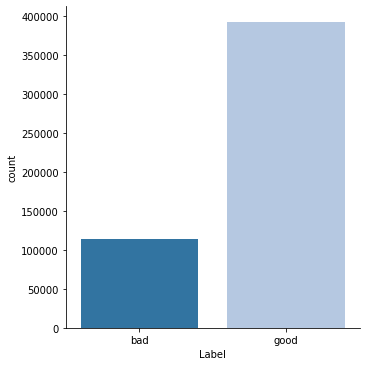

In [147]:
ax = sns.catplot("Label",
                data=data,
                kind="count", 
                palette='tab20');

## Feature engineering/Data preprocessing

In [148]:
def url_path_to_dict(path):
    pattern = (r'^'
               r'((?P<schema>.+?)://)?'
               r'((?P<user>.+?)(:(?P<password>.*?))?@)?'
               r'(?P<host>.*?)'
               r'(:(?P<port>\d+?))?'
               r'(?P<path>/.*?)?'
               r'(?P<query>[?].*?)?'
               r'$'
               )
    regex = re.compile(pattern)
    m = regex.match(path)
    d = m.groupdict() if m is not None else None
    return d


url = data['URL'].iloc[0]
print(url)
print(url_path_to_dict(url))

nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526
{'schema': None, 'user': None, 'password': None, 'host': 'nobell.it', 'port': None, 'path': '/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php', 'query': '?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'}


In [149]:
VOWELS = set("aeiou")
CONSONANTS = set(string.ascii_lowercase) - set("aeiou")

def url_length(s: str):
    return len(s)

def hostname_length(d: dict):
    if not d:
        return 0

    if not d['host']:
        return 0
    else:
        return len(d['host'])

def path_length(d: dict):
    if not d:
        return 0

    if not d['path']:
        return 0
    else:
        return len(d['path'])

def query_length(d: dict):
    if not d:
        return 0

    if not d['query']:
        return 0
    else:
        return len(d['query'])

def is_ip(d:dict):
    if not d:
        return False

    res_s = re.sub(r'[/.]', '', d['host'])
    return int(res_s.isnumeric())

def contains_port(d:dict):
    if not d:
        return False

    if d['port']:
        return 1
    else:
        return 0

def contains_username(d:dict):
    if not d:
        return False

    if d['user']:
        return 1
    else:
        return 0

def vowels_pct(s):
    count = 0
    s = s.lower()

    for ch in s:
        if ch in VOWELS:
            count = count + 1

    return count/len(s)

def consonants_pct(s):
    count = 0
    s = s.lower()

    for ch in s:
        if ch in CONSONANTS:
            count = count + 1

    return count/len(s)

def count_dots(s):
    return s.count('.')

def count_slash(s):
    return s.count('/')

def count_digits(s):
    return len(re.sub(r"\D", "", s))

def count_punctuation(s):
    return len(re.sub(r"[^" + string.punctuation + "]+", "", s))

def extract_doc(s):
    return " ".join(re.split("[" + string.punctuation + "]+", s))

In [150]:
%%time

data['url_info'] = data['URL'].apply(lambda x: url_path_to_dict(x))
data['doc'] = data['URL'].apply(lambda x: extract_doc(x))

data['vowels_pct'] = data['URL'].apply(lambda x: vowels_pct(x))
data['consonants_pct'] = data['URL'].apply(lambda x: consonants_pct(x))
data['is_ip'] = data['url_info'].apply(lambda x: is_ip(x))
data['contains_port'] = data['url_info'].apply(lambda x: contains_port(x))
data['contains_username'] = data['url_info'].apply(lambda x: contains_username(x))

# need to be normalized
data['url_length'] = data['URL'].apply(lambda x: url_length(x))
data['dots_num'] = data['URL'].apply(lambda x: count_dots(x))
data['slash_num'] = data['URL'].apply(lambda x: count_slash(x))
data['digits_num'] = data['URL'].apply(lambda x: count_digits(x))
data['punct_num'] = data['URL'].apply(lambda x: count_punctuation(x))
data['host_length'] = data['url_info'].apply(lambda x: hostname_length(x))
data['path_length'] = data['url_info'].apply(lambda x: path_length(x))
data['query_length'] = data['url_info'].apply(lambda x: query_length(x))

CPU times: user 22.2 s, sys: 142 ms, total: 22.3 s
Wall time: 22.3 s


In [151]:
data.head()

,URL,Label,url_info,doc,vowels_pct,consonants_pct,is_ip,contains_port,contains_username,url_length,dots_num,slash_num,digits_num,punct_num,host_length,path_length,query_length
0,nobell.it/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526,bad,"{'schema': None, 'user': None, 'password': None, 'host': 'nobell.it', 'port': None, 'path': '/70ffb52d079109dca5664cce6f317373782/login.SkyPe.com/en/cgi-bin/verification/login/70ffb52d079109dca5664cce6f317373/index.php', 'query': '?cmd=_profile-ach&outdated_page_tmpl=p/gen/failed-to-load&nav=0.5.1&login_access=1322408526'}",nobell it 70ffb52d079109dca5664cce6f317373782 login SkyPe com en cgi bin verification login 70ffb52d079109dca5664cce6f317373 index php cmd profile ach outdated page tmpl p gen failed to load nav 0 5 1 login access 1322408526,0.204444,0.395556,0,0,0,225,6,10,58,32,9,125,91
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php,bad,"{'schema': None, 'user': None, 'password': None, 'host': 'www.dghjdgf.com', 'port': None, 'path': '/paypal.co.uk/cycgi-bin/webscrcmd=_home-customer&nav=1/loading.php', 'query': None}",www dghjdgf com paypal co uk cycgi bin webscrcmd home customer nav 1 loading php,0.209877,0.592593,0,0,0,81,5,4,1,15,15,66,0
2,serviciosbys.com/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/,bad,"{'schema': None, 'user': None, 'password': None, 'host': 'serviciosbys.com', 'port': None, 'path': '/paypal.cgi.bin.get-into.herf.secure.dispatch35463256rzr321654641dsf654321874/href/href/href/secure/center/update/limit/seccure/4d7a1ff5c55825a2e632a679c2fd5353/', 'query': None}",serviciosbys com paypal cgi bin get into herf secure dispatch35463256rzr321654641dsf654321874 href href href secure center update limit seccure 4d7a1ff5c55825a2e632a679c2fd5353,0.214689,0.412429,0,0,0,177,7,11,47,19,16,161,0
3,mail.printakid.com/www.online.americanexpress.com/index.html,bad,"{'schema': None, 'user': None, 'password': None, 'host': 'mail.printakid.com', 'port': None, 'path': '/www.online.americanexpress.com/index.html', 'query': None}",mail printakid com www online americanexpress com index html,0.300000,0.566667,0,0,0,60,6,2,0,8,18,42,0
4,thewhiskeydregs.com/wp-content/themes/widescreen/includes/temp/promocoessmiles/?84784787824HDJNDJDSJSHD//2724782784/,bad,"{'schema': None, 'user': None, 'password': None, 'host': 'thewhiskeydregs.com', 'port': None, 'path': '/wp-content/themes/widescreen/includes/temp/promocoessmiles/', 'query': '?84784787824HDJNDJDSJSHD//2724782784/'}",thewhiskeydregs com wp content themes widescreen includes temp promocoessmiles 84784787824HDJNDJDSJSHD 2724782784,0.198276,0.508621,0,0,0,116,1,10,21,13,19,60,37


In [152]:
data['Label'] = data.Label.apply(lambda x: 0 if x=='bad' else 1)

In [153]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

X = data.iloc[:, 3:]
y = data.Label.values

In [154]:
tf_idf_vec = TfidfVectorizer(encoding='utf-8', 
                             stop_words='english', 
                             ngram_range=(1, 3), 
                             max_df=0.8, min_df=1000)

sc = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)

In [155]:
NOT_SCALE_COLUMNS = ["vowels_pct",	"consonants_pct",	"is_ip",	"contains_port",	"contains_username"]
TO_SCALE_COLUMNS = ["url_length",	"dots_num",	"slash_num",	"digits_num",	"punct_num",	"host_length",	"path_length",	"query_length"]

GOOD_SAMPLES = ['youtube.com/',
                'youtube.com/watch?v=qI0TQJI3vdU',
                'bestbuy.com/',
                'restorevisioncenters.com/html/technology.html',
                'mariazork.github.io/CodingProblems']

BAD_SAMPLES = ['http://shadetreetechnology.com/V4/validation/a111aedc8ae390eabcfa130e041a10a4', 
               'yeniik.com.tr/wp-admin/js/login.alibaba.com/login.jsp.php',
               'fazan-pacir.rs/temp/libraries/ipad',
               'tubemoviez.exe',
               'svision-online.de/mgfi/administrator/components/com_babackup/classes/fx29id1.txt']

In [156]:
def preprocess(Xtrain, Xval, vectorizer, scaler, fold_index):
    Xtrain_vect = vectorizer.fit_transform(Xtrain.doc.values)
    Xtrain_num = scaler.fit_transform(Xtrain.loc[:, TO_SCALE_COLUMNS].values)
    Xtrain_num = coo_matrix(Xtrain_num)
    Xtrain_num_add = coo_matrix(Xtrain.loc[:, NOT_SCALE_COLUMNS].values).astype('float32')
    Xtrain_res = hstack([Xtrain_vect, Xtrain_num_add, Xtrain_num])
    Xtrain_res = Xtrain_res.astype('float32')

    Xval_vect = vectorizer.transform(Xval.doc.values)    
    Xval_num = scaler.transform(Xval.loc[:, TO_SCALE_COLUMNS].values)
    Xval_num = coo_matrix(Xval_num)
    Xval_num_add = coo_matrix(Xval.loc[:, NOT_SCALE_COLUMNS].values).astype('float32')
    Xval_res = hstack([Xval_vect, Xval_num_add, Xval_num])
    Xval_res = Xval_res.astype('float32')

    pickle.dump(vectorizer, open(f"tf_idf_{fold_index}.pkl", "wb"))
    pickle.dump(scaler, open(f"scaler_{fold_index}.pkl", "wb"))

    return Xtrain_res, Xval_res

def train(model, X, y, vectorizer, scaler):
    precision_scores, recall_scores = [], []

    for fold_idx, (train_index, val_index) in enumerate(folds.split(X, y)):
        X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
        y_train, y_val = y[train_index], y[val_index]

        X_train_, X_val_ = preprocess(X_train, X_val, vectorizer, scaler, fold_idx)

        model.fit(X_train_, y_train)

        y_hat = model.predict(X_val_)
        
        precision_scores.append(precision_score(y_val, y_hat))
        recall_scores.append(recall_score(y_val, y_hat))

        pickle.dump(model, open(f"model_{fold_idx}.pkl", "wb"))

    return precision_scores, recall_scores

def infer(sample: np.array,
          model_filename: str,
          vectorizer_filename: str,
          scaler_filename: str):
    model = pickle.load(open(model_filename, "rb"))
    tf_idf_vec = pickle.load(open(vectorizer_filename, "rb"))
    sc = pickle.load(open(scaler_filename, "rb"))

    feature_vec = np.array([])

    url_info = url_path_to_dict(sample)
    doc = extract_doc(sample)

    feature_vec = np.append(feature_vec, tf_idf_vec.transform(np.array([doc])).toarray())

    feature_vec = np.append(feature_vec, vowels_pct(sample))
    feature_vec = np.append(feature_vec, consonants_pct(sample))
    feature_vec = np.append(feature_vec, is_ip(url_info))
    feature_vec = np.append(feature_vec, contains_port(url_info))
    feature_vec = np.append(feature_vec, contains_username(url_info))

    feature_vec = np.append(feature_vec, 
                            sc.transform(np.array([[url_length(sample), 
                                          count_dots(sample), 
                                          count_slash(sample), 
                                          count_digits(sample), 
                                          count_punctuation(sample), 
                                          hostname_length(url_info), 
                                          path_length(url_info), 
                                          query_length(url_info)]])))

    y_hat = model.predict(feature_vec.reshape(1, -1))

    return y_hat

## Logistic regression

In [157]:
lr = LogisticRegression(penalty='l2', 
                        tol=0.0001, 
                        C=0.01, 
                        class_weight='balanced', 
                        random_state=SEED, 
                        solver='lbfgs', 
                        max_iter=100,
                        n_jobs=-1)

precision_scores, recall_scores = train(lr, X, y, tf_idf_vec, sc)
print("==Logistic regression results==")
print("Precision scores:\n", "\n".join(map(str, precision_scores)))
print("="*20)
print("Recall scores:\n", "\n".join(map(str, recall_scores)))
print("="*20)
print("Mean recall over folds", np.mean(recall_scores))
print("Std of recall over folds", np.std(recall_scores))

print("Mean precision over folds", np.mean(precision_scores))
print("Std of precision over folds", np.std(precision_scores))

==Logistic regression results==
Precision scores:
 0.93784306550264
0.9394603245398854
0.9352301342125074
0.9387226358556979
0.9379541570453863
Recall scores:
 0.91320946805803
0.911388538922613
0.9169370951526489
0.9129665686761094
0.9149529142275388
Mean recall over folds 0.913890917007388
Std of recall over folds 0.0018967196933418495
Mean precision over folds 0.9378420634312233
Std of precision over folds 0.0014303088503269622


In [158]:
answers = []

for sample in GOOD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([1]), array([1]), array([1]), array([1]), array([1])]


In [159]:
answers = []

for sample in BAD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([0]), array([0]), array([1]), array([0]), array([0])]


# SGD Classifier

In [160]:
sgd = SGDClassifier(random_state=SEED, 
                    class_weight='balanced',
                    n_jobs=-1)

precision_scores, recall_scores = train(sgd, X, y, tf_idf_vec, sc)
print("==SGD classifier results==")
print("Precision scores:\n", "\n".join(map(str, precision_scores)))
print("="*20)
print("Recall scores:\n", "\n".join(map(str, recall_scores)))
print("="*20)
print("Mean recall over folds", np.mean(recall_scores))
print("Std of recall over folds", np.std(recall_scores))

print("Mean precision over folds", np.mean(precision_scores))
print("Std of precision over folds", np.std(precision_scores))

==SGD classifier results==
Precision scores:
 0.9341991999594916
0.9406067274844224
0.9423525535420099
0.9426472102120651
0.9424178044925772
Recall scores:
 0.9391448205650292
0.9355553010346276
0.9099250435867089
0.9322465289708446
0.9257953677780606
Mean recall over folds 0.9285334123870541
Std of recall over folds 0.010290426775929541
Mean precision over folds 0.9404446991381132
Std of precision over folds 0.003206762272833252


In [161]:
answers = []

for sample in GOOD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([1]), array([1]), array([1]), array([1]), array([0])]


In [162]:
answers = []

for sample in BAD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([0]), array([0]), array([0]), array([0]), array([0])]


# Random forest

In [163]:
rf = RandomForestClassifier(max_depth=100,
                            random_state=SEED,
                            class_weight='balanced',
                            n_jobs=-1)

precision_scores, recall_scores = train(rf, X, y, tf_idf_vec, sc)
print("==Random forest results==")
print("Precision scores:\n", "\n".join(map(str, precision_scores)))
print("="*20)
print("Recall scores:\n", "\n".join(map(str, recall_scores)))
print("="*20)
print("Mean recall over folds", np.mean(recall_scores))
print("Std of recall over folds", np.std(recall_scores))

print("Mean precision over folds", np.mean(precision_scores))
print("Std of precision over folds", np.std(precision_scores))

==Random forest results==
Precision scores:
 0.9654844323146838
0.9651363306925249
0.9635700820234959
0.9653545868575146
0.9646089608960896
Recall scores:
 0.981420208704505
0.9829089196859212
0.9822089871339671
0.9818781099275888
0.9819419699669127
Mean recall over folds 0.9820716390837789
Std of recall over folds 0.000489598293873607
Mean precision over folds 0.9648308785568618
Std of precision over folds 0.0006976473682924858


In [164]:
answers = []

for sample in GOOD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([1]), array([1]), array([1]), array([1]), array([1])]


In [165]:
answers = []

for sample in BAD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([0]), array([0]), array([0]), array([0]), array([0])]


# Linear SVM

In [166]:
linear_svm = LinearSVC(random_state=SEED,
                       class_weight='balanced')

precision_scores, recall_scores = train(linear_svm, X, y, tf_idf_vec, sc)
print("==Support Vector Machines results==")
print("Precision scores:\n", "\n".join(map(str, precision_scores)))
print("="*20)
print("Recall scores:\n", "\n".join(map(str, recall_scores)))
print("="*20)
print("Mean recall over folds", np.mean(recall_scores))
print("Std of recall over folds", np.std(recall_scores))

print("Mean precision over folds", np.mean(precision_scores))
print("Std of precision over folds", np.std(precision_scores))

==Logistic regression results==
Precision scores:
 0.9531297649195847
0.9549273129228915
0.9496824749858659
0.950237309527879
0.9489986333052985
Recall scores:
 0.9148129294986002
0.9069980529149009
0.9192023314117004
0.9197877295460619
0.918999745482311
Mean recall over folds 0.9159601577707148
Std of recall over folds 0.004817396500707926
Mean precision over folds 0.9513950991323039
Std of precision over folds 0.0022584156548811265


In [167]:
answers = []

for sample in GOOD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([1]), array([1]), array([1]), array([1]), array([0])]


In [168]:
answers = []

for sample in BAD_SAMPLES:
    answers.append(infer(sample, "model_0.pkl", "tf_idf_0.pkl", "scaler_0.pkl"))

print(answers)

[array([0]), array([0]), array([0]), array([0]), array([0])]
